In [1]:
import numpy as np
import os
import pandas as pd
import time
import math
import re
from itertools import groupby
from operator import itemgetter
# package for io 
from aicsimageio.writers import OmeTiffWriter
from aicsimageio.readers import tiff_reader, OmeTiffReader


import itertools
from skimage import measure as skmeasure
import datetime
from CustomFunctions import shparam_mod

from skimage.morphology import disk
from skimage.filters import median, gaussian


from scipy.spatial import KDTree, distance
from scipy import interpolate
from aicsimageio.readers.bioformats_reader import BioformatsReader
from CustomFunctions.segment_cells2short import seg_confocal_40x_memonly_fromslices
from CustomFunctions.persistance_activity import get_pa, velocity_and_distance, DA_3D
from CustomFunctions.track_functions import segment_caax_tracks_confocal_40x_fromsingle
from CustomFunctions.file_management import multicsv

# load in some stuff to speed up processing
# (following https://sedeh.github.io/python-pandas-multiprocessing-workaround.html)
import multiprocessing

def collect_results(result):
    """Uses apply_async's callback to setup up a separate Queue for each process.
    This will allow us to collect the results from different threads."""
    results.append(result)
    

def mygrouper(n, iterable):
    args = [iter(iterable)] * n
    return ([e for e in t if e != None] for t in itertools.zip_longest(*args))
    


def get_intensity_features(img, seg):
    features = {}
    input_seg = seg.copy()
    input_seg = (input_seg>0).astype(np.uint8)
    input_seg_lcc = skmeasure.label(input_seg)
    for mask, suffix in zip([input_seg, input_seg_lcc], ['', '_lcc']):
        values = img[mask>0].flatten()
        if values.size:
            features[f'intensity_mean{suffix}'] = values.mean()
            features[f'intensity_std{suffix}'] = values.std()
            features[f'intensity_1pct{suffix}'] = np.percentile(values, 1)
            features[f'intensity_99pct{suffix}'] = np.percentile(values, 99)
            features[f'intensity_max{suffix}'] = values.max()
            features[f'intensity_min{suffix}'] = values.min()
        else:
            features[f'intensity_mean{suffix}'] = np.nan
            features[f'intensity_std{suffix}'] = np.nan
            features[f'intensity_1pct{suffix}'] = np.nan
            features[f'intensity_99pct{suffix}'] = np.nan
            features[f'intensity_max{suffix}'] = np.nan
            features[f'intensity_min{suffix}'] = np.nan
    return features



def dist_f(a1, b1, c1, a2, b2, c2):

    d = ( a1 * a2 + b1 * b2 + c1 * c2 )
    e1 = math.sqrt( a1 * a1 + b1 * b1 + c1 * c1)
    e2 = math.sqrt( a2 * a2 + b2 * b2 + c2 * c2)
    d = d / (e1 * e2)
    A = math.degrees(math.acos(d))
    return A

# Function to find Angle
def angle_distance(a1, b1, c1, a2, b2, c2):
    a1,b1,c1 = [a1,b1,c1]/np.linalg.norm([a1,b1,c1])
    a2,b2,c2 = [a2,b2,c2]/np.linalg.norm([a2,b2,c2])
    d = ( a1 * a2 + b1 * b2 + c1 * c2 )
    e1 = math.sqrt( a1 * a1 + b1 * b1 + c1 * c1)
    e2 = math.sqrt( a2 * a2 + b2 * b2 + c2 * c2)
    d = d / (e1 * e2)
    A = math.degrees(math.acos(d))
    return A

In [3]:
############################# RUN TRACKMATE TRACKING ON SEGMENTED IMAGES ##################################

In [7]:
from CustomFunctions.track_functions import segment_caax_tracks_confocal_40x_fromsingle

#### get together all images on the NAS #########

ip = 0.3394 #um / pixel .2285
step = 0.7 # um

#### directory info
bigdir = '//10.158.28.37/ExpansionHomesA/avlnas/HL60 ParaNitroBlebbistatin/'
# foldlist = ['20240624','20240626','20240701','2024']
foldlist = ['20241126','20241127']#,'20241125']
savedir = 'E:/Aaron/ParaNitroBlebbistatin_37C/Tracking_Images/'

####  TZYX shape of the image
imshape = (181,150,1024,1024)

for f in foldlist:
    ims = [o for o in os.listdir(bigdir+f+'/')]
    for i in ims:

        #make the savedir if it doesn't exist
        if not os.path.exists(savedir+i+'/'):
            os.makedirs(savedir+i+'/')
        #directory of all the slices for this movie
        imdir = bigdir+f+'/'+i+'/Default/'


        ##### automatically detect image size
        #         #sort the list of images and get the last one
        #         last = sorted([o for o in os.listdir(imdir) if o.endswith('tif')])[-1]
        #         #get stats about acquisition
        #         cc,pos,maxtime,maxslices = [x for x in re.findall('\d*', last) if len(x)>1]
        #         maxtime = int(maxtime)+1
        #         maxslices = int(maxslices)+1
        #         #open that image to get x,y size
        #         shape = tiff_reader.TiffReader(imdir+last).shape

        results = []
        if __name__ ==  '__main__':
        # use multiprocessing to perform segmentation and x,y,z determination
            pool = multiprocessing.Pool(processes=60)
            for t in range(imshape[0]):
                pool.apply_async(segment_caax_tracks_confocal_40x_fromsingle, args=(imdir,
                                                                                    imshape[-3:],
                                                                                    ip,
                                                                                    step,
                                                                                    t, ), 
                                 callback=collect_results)
            pool.close()
            pool.join()



        #organize the semented frames into a segmented stack
        segmented_img = np.zeros((imshape[0],
                                 results[0][3][-3],
                                 results[0][3][-2],
                                 results[0][3][-1]))
        for r in results:
            fr = r[2]
            segmented_img[fr,:,:,:] = r[1]    

        #covert to more compact data type
        segmented_img = segmented_img.astype(np.uint8)

        #save the segmented image
        OmeTiffWriter.save(segmented_img, savedir+i+'/'+i+'_segmented.ome.tiff', dim_order = "TZYX", overwrite_file=True)


        #save the skimage region props
        df = pd.DataFrame()
        for d in results:
            df = df.append(pd.DataFrame(d[0], columns = ['cell', 
                         'frame', 'z_min', 'y_min', 
                        'x_min','z_max', 'y_max', 'x_max',
                       'z', 'y', 'x', 'z_range',
                       'area', 'convex_area', 'extent',
                       'minor_axis_length', 'major_axis_length',
                        'intensity_avg', 'intensity_max', 'intensity_std']))
        df = df.sort_values(by = ['frame','cell'])
        df.to_csv(savedir+i+'/'+i+'_region_props.csv')

        print(f'Finished processing {i}')

Finished processing 20241127_488EGFP-CAAX_01perDMSO_37C_3


In [5]:
############### SEGMENT AND SAVE CELLS ################################

############## alignment by chemical gradient ###################

from scipy.spatial import KDTree, distance
from itertools import groupby
from operator import itemgetter
from scipy import interpolate
import re
from aicsimageio.readers.bioformats_reader import BioformatsReader

#import the cell segmentation and rotation function
# import sys
# # insert at 1, 0 is the script path (or '' in REPL)
# import_path = 'C:/Users/Aaron/Documents/PythonScripts/CustomFunctions'
# sys.path.insert(1, import_path)
from CustomFunctions.segment_cells2short import seg_confocal_40x_memonly_fromslices

from CustomFunctions.persistance_activity import get_pa, velocity_and_distance, DA_3D


# path to folder(s)
base = 'E:/Aaron/ParaNitroBlebbistatin_37C/'
folder_fl = base + 'Tracking_Images/'
filelist_fl = [f for f in os.listdir(folder_fl)]
savedir = base + 'processed_images/'
csvdir = base + 'processed_data/'
datadir = base + 'Data_and_Figs/'
#make the savedir if it doesn't exist
if not os.path.exists(savedir):
    os.makedirs(savedir)
if not os.path.exists(datadir):
    os.makedirs(datadir)
raw_dir = '//10.158.28.37/ExpansionHomesA/avlnas/HL60 ParaNitroBlebbistatin/'

#parameters for segmentation
xy_buffer = 20 #pixels
z_buffer = 10 #pixels
xyres = 0.3394 #um / pixel 
zstep = 0.7 # um
interval = 10
intthresh = 120 #for the half shrunken images, determined by manually crossreferencing
imshape = (150,1024,1024)


# u = filelist_fl[0]

for u in filelist_fl:

    ################## align trackmate data with region props data ################
    rpcsv = [x for x in os.listdir(folder_fl + u) if x.endswith("region_props.csv")][0]
    rp = pd.read_csv(folder_fl + u + '/' + rpcsv, index_col = 0)
    tmcsv = [x for x in os.listdir(folder_fl + u) if x.endswith("TrackMateLog.csv")][0]
    tm = pd.read_csv(folder_fl + u+ '/' + tmcsv)
    #fix trackmate columns to get names right and units in microns
    tm['x'] = tm.POSITION_X*xyres
    tm['y'] = tm.POSITION_Y*xyres
    tm['z'] = tm.POSITION_Z*zstep
    #make kdtree and query with trackmate log
    kd = KDTree(rp[['frame','x','y','z']].to_numpy())
    dd, ii = kd.query(tm[['FRAME','x','y','z']])
    df_track = pd.concat([tm.drop(columns=['POSITION_X','POSITION_Y','POSITION_Z']), 
                        rp.iloc[ii].drop(columns=['frame','x','y','z', 'cell']).reset_index(drop=True)], axis=1)
    df_track = df_track.rename(columns={'TRACK_ID':'cell', 'FRAME':'frame'})
    #sort by cell and frame
    df_track = df_track.sort_values(['cell','frame'])



    #############find distance travelled##################
    longdistmatrix = distance.pdist(df_track[['x','y','z']])
    shortdistmatrix = distance.squareform(longdistmatrix)
    shortdistmatrix = np.array(shortdistmatrix)
    dist = pd.Series([], dtype = 'float64')
    for count, i in enumerate(shortdistmatrix):
        if count == 0:
            temp = pd.Series([0])
            dist = dist.append(temp, ignore_index=True)
        else:
            temp = pd.Series(shortdistmatrix[count,count-1])
            dist = dist.append(temp, ignore_index=True)
    df_track = df_track.reset_index(drop = True)
    df_track['dist'] = dist
    #     #first rows that have super long distances from previous cell, so set them to 0
    #     df_track.loc[df_track.groupby('cell').head(1).index,'dist'] = 0

    ############ replace unrealistic jumps in distance ##############
    for x in df_track[df_track.dist>4].index.values:
        df_track['dist'][x] = df_track.dist.mean()

    ############## find euclidean distance #############
    euclid = pd.DataFrame([])
    for i, cell in df_track.groupby('cell'):
        FL = cell.iloc[[0,-1]]
        euc_dist = distance.pdist(FL[['x','y','z']])
        euclid = euclid.append({'cell':cell.cell.iloc[0], 'euc_dist':euc_dist[0]}, ignore_index = True)
    cellsmorethan = euclid.loc[euclid['euc_dist']>10, 'cell']
    df_track = df_track[df_track.cell.isin(cellsmorethan)]

    #     ########remove "slow"/dead cells############
    #     #sum distances
    #     df_track_distsums = df_track.groupby('cell').sum()
    #     df_track_distsums = df_track_distsums.add_suffix('_sum').reset_index()

    #     #grab only cells with sums above a threshold distance
    #     cellsmorethan = df_track_distsums.loc[df_track_distsums['dist_sum']>5, 'cell']
    #     df_track = df_track[df_track.cell.isin(cellsmorethan)]


    ########remove edge cells############
    #only grab rows that aren't zero in z_min
    df_track = df_track.loc[df_track['x_min'] !=0 ]
    df_track = df_track.loc[df_track['y_min'] !=0 ]
    df_track = df_track.loc[df_track['z_min'] !=0 ]
    #remove rows where z_max matches z_range
    df_track = df_track.loc[df_track['x_max'] < imshape[-1]]
    df_track = df_track.loc[df_track['y_max'] < imshape[-2]]
    df_track = df_track.loc[df_track['z_max'] != (df_track['z_range'])]


    ##########remove small things that are likely dead cells or parts of cells###########
    df_track = df_track[df_track['area'] > 4000 ]


    #reset index after dropping all the rows
    df_track = df_track.reset_index(drop = True)



    ######## remove cells that touch ###########    
    to_remove = []
    for i, cell in df_track.groupby('cell'):
        if i>0:
            changes = abs(cell['convex_area'].pct_change())
            largerthan = changes[changes>0.75]
            if largerthan.empty == False:
                to_remove.extend(largerthan.index.to_list())


            # changes = cell['convex_area'].diff()
            # largerthan = changes[changes>cell['convex_area']*0.333]
            # smallerthan = changes[changes<cell['convex_area']*-0.333]
            # print(largerthan.index,smallerthan.index)
            # #remove all frames of a cell after it contacts another cell
            # if largerthan.empty == False:
            #     for n in largerthan.index:
            #         to_remove.append(list(range(n, max(cell.index)+1)))
            # #remove all frames of a cell before it splits from another cell
            # if smallerthan.empty == False:
            #     for n in smallerthan.index:
            #         to_remove.append(list(range(cell.index[0], n-1)))
    # #remove duplicate indicies
    # to_remove = [j for x in to_remove for j in x]
    # to_remove = list(set(to_remove))
    #drop touching or splitting cells
    df_track = df_track.drop(to_remove)



    if df_track.empty == False:
        for i, cells in df_track.groupby('cell'):
            cells = cells.reset_index(drop = True)
            runs = list()
            #######https://stackoverflow.com/questions/2361945/detecting-consecutive-integers-in-a-list
            for k, g in groupby(enumerate(cells['frame']), lambda ix: ix[0] - ix[1]):
                currentrun = list(map(itemgetter(1), g))
                list.append(runs, currentrun)
            for r in runs:
                r = np.array(r, dtype=int)
                #skip runs less than 3 frames long
                if len(r)<3:
                    pass
                else:
                    cell = cells.iloc[[cells[cells.frame==y].index[0] for y in r]]
                    #segment the cell channel and get centroid
                    df = pd.DataFrame()
                    if __name__ ==  '__main__':
                        # use multiprocessing to perform segmentation and x,y,z determination
                        pool = multiprocessing.Pool(processes=60)
                        results = []
                        for t, row in cell.iterrows():

                            tdir = raw_dir +u.split('_')[0]+'/' +u+'/Default/'

                            xmincrop = int(max(0, row.x_min-xy_buffer))
                            ymincrop = int(max(0, row.y_min-xy_buffer))
                            zmincrop = int(max(0, row.z_min-z_buffer))

                            zmaxcrop = int(min(row.z_max+z_buffer, imshape[-3]))
                            ymaxcrop = int(min(row.y_max+xy_buffer, imshape[-2])+1)
                            xmaxcrop = int(min(row.x_max+xy_buffer, imshape[-1])+1)

                            pool.apply_async(seg_confocal_40x_memonly_fromslices, args = (
                                tdir,
                                imshape,
                                row,
                                u,
                                savedir,
                                xyres,
                                zstep,
                                xmincrop, 
                                ymincrop, 
                                zmincrop,
                                xmaxcrop, 
                                ymaxcrop, 
                                zmaxcrop,
                                ),             
                                callback = collect_results)

                        pool.close()
                        pool.join()

                        print(f'Done segmenting {u} cell {cell.cell.iloc[0]}')

                    if any([x == None for x in results]):
                        ind = results.index(None)
                        if len(results[:ind])<3:
                            pass
                        else:
                            results = results[:ind]

                    #aggregate the dataframe
                    for d in results:
                        df = df.append(pd.DataFrame(d, columns = d.keys(), index=[0]))
                    df = df.sort_values(by = 'frame').reset_index(drop=True)
                    #save the position info
                    df.to_csv(posdir+df.iloc.cell.split('_frame')[0]+'_cellpos.csv')


C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done segmenting 20240624_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_2 cell 3
Done segmenting 20240624_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_2 cell 3
Done segmenting 20240624_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_2 cell 3
Done segmenting 20240624_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_2 cell 3
Done segmenting 20240624_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_2 cell 3
Done segmenting 20240624_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_2 cell 4
Done segmenting 20240624_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_2 cell 7
Done segmenting 20240624_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_2 cell 8
Done segmenting 20240624_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_2 cell 13
Done segmenting 20240624_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_2 cell 17
Done segmenting 20240624_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_2 cell 18
Done segmenting 20240624_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_2 cell 18
Done segmenting 20240624_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_2 ce

Done segmenting 20240701_488EGFP-CAAX_01perDMSO_37C_3 cell 11
Done segmenting 20240701_488EGFP-CAAX_01perDMSO_37C_3 cell 12
Done segmenting 20240701_488EGFP-CAAX_01perDMSO_37C_3 cell 13
Done segmenting 20240701_488EGFP-CAAX_01perDMSO_37C_3 cell 18
Done segmenting 20240701_488EGFP-CAAX_01perDMSO_37C_3 cell 22
Done segmenting 20240701_488EGFP-CAAX_01perDMSO_37C_4 cell 1
Done segmenting 20240701_488EGFP-CAAX_01perDMSO_37C_4 cell 1
Done segmenting 20240701_488EGFP-CAAX_01perDMSO_37C_4 cell 1
Done segmenting 20240701_488EGFP-CAAX_01perDMSO_37C_4 cell 4
Done segmenting 20240701_488EGFP-CAAX_01perDMSO_37C_4 cell 5
Done segmenting 20240701_488EGFP-CAAX_01perDMSO_37C_4 cell 6
Done segmenting 20240701_488EGFP-CAAX_01perDMSO_37C_4 cell 7
Done segmenting 20240701_488EGFP-CAAX_01perDMSO_37C_4 cell 8
Done segmenting 20240701_488EGFP-CAAX_01perDMSO_37C_4 cell 9
Done segmenting 20240701_488EGFP-CAAX_01perDMSO_37C_4 cell 10
Done segmenting 20240701_488EGFP-CAAX_01perDMSO_37C_4 cell 11
Done segmenting 2

Done segmenting 20241125_488EGFP-CAAX_01perDMSO_37C_1 cell 45
Done segmenting 20241125_488EGFP-CAAX_01perDMSO_37C_1 cell 48
Done segmenting 20241125_488EGFP-CAAX_01perDMSO_37C_1 cell 48
Done segmenting 20241125_488EGFP-CAAX_01perDMSO_37C_1 cell 49
Done segmenting 20241125_488EGFP-CAAX_01perDMSO_37C_1 cell 51
Done segmenting 20241125_488EGFP-CAAX_01perDMSO_37C_1 cell 51
Done segmenting 20241125_488EGFP-CAAX_01perDMSO_37C_1 cell 52
Done segmenting 20241125_488EGFP-CAAX_01perDMSO_37C_1 cell 53
Done segmenting 20241125_488EGFP-CAAX_01perDMSO_37C_1 cell 53
Done segmenting 20241125_488EGFP-CAAX_01perDMSO_37C_1 cell 54
Done segmenting 20241125_488EGFP-CAAX_01perDMSO_37C_1 cell 54
Done segmenting 20241125_488EGFP-CAAX_01perDMSO_37C_1 cell 54
Done segmenting 20241125_488EGFP-CAAX_01perDMSO_37C_1 cell 55
Done segmenting 20241125_488EGFP-CAAX_01perDMSO_37C_1 cell 57
Done segmenting 20241125_488EGFP-CAAX_01perDMSO_37C_1 cell 57
Done segmenting 20241125_488EGFP-CAAX_01perDMSO_37C_1 cell 57
Done seg

Done segmenting 20241125_488EGFP-CAAX_01perDMSO_37C_3 cell 2
Done segmenting 20241125_488EGFP-CAAX_01perDMSO_37C_3 cell 3
Done segmenting 20241125_488EGFP-CAAX_01perDMSO_37C_3 cell 4
Done segmenting 20241125_488EGFP-CAAX_01perDMSO_37C_3 cell 5
Done segmenting 20241125_488EGFP-CAAX_01perDMSO_37C_3 cell 5
Done segmenting 20241125_488EGFP-CAAX_01perDMSO_37C_3 cell 6
Done segmenting 20241125_488EGFP-CAAX_01perDMSO_37C_3 cell 6
Done segmenting 20241125_488EGFP-CAAX_01perDMSO_37C_3 cell 7
Done segmenting 20241125_488EGFP-CAAX_01perDMSO_37C_3 cell 7
Done segmenting 20241125_488EGFP-CAAX_01perDMSO_37C_3 cell 8
Done segmenting 20241125_488EGFP-CAAX_01perDMSO_37C_3 cell 8
Done segmenting 20241125_488EGFP-CAAX_01perDMSO_37C_3 cell 10
Done segmenting 20241125_488EGFP-CAAX_01perDMSO_37C_3 cell 11
Done segmenting 20241125_488EGFP-CAAX_01perDMSO_37C_3 cell 11
Done segmenting 20241125_488EGFP-CAAX_01perDMSO_37C_3 cell 13
Done segmenting 20241125_488EGFP-CAAX_01perDMSO_37C_3 cell 18
Done segmenting 202

Done segmenting 20241125_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_1 cell 31
Done segmenting 20241125_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_1 cell 32
Done segmenting 20241125_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_1 cell 32
Done segmenting 20241125_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_1 cell 32
Done segmenting 20241125_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_1 cell 32
Done segmenting 20241125_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_1 cell 39
Done segmenting 20241125_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_1 cell 39
Done segmenting 20241125_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_1 cell 42
Done segmenting 20241125_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_1 cell 43
Done segmenting 20241125_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_1 cell 43
Done segmenting 20241125_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_1 cell 44
Done segmenting 20241125_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_1 cell 45
Done segmenting 20241125_488EGFP-CAAX_10uMParaNitroBlebbistatin_

Done segmenting 20241125_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_3 cell 27
Done segmenting 20241125_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_3 cell 28
Done segmenting 20241125_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_3 cell 29
Done segmenting 20241125_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_3 cell 30
Done segmenting 20241125_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_3 cell 30
Done segmenting 20241125_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_3 cell 30
Done segmenting 20241125_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_3 cell 32
Done segmenting 20241125_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_3 cell 33
Done segmenting 20241125_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_3 cell 34
Done segmenting 20241125_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_3 cell 34
Done segmenting 20241125_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_3 cell 36
Done segmenting 20241125_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_3 cell 37
Done segmenting 20241125_488EGFP-CAAX_10uMParaNitroBlebbistatin_

Done segmenting 20241126_488EGFP-CAAX_01perDMSO_37C_1 cell 109
Done segmenting 20241126_488EGFP-CAAX_01perDMSO_37C_1 cell 112
Done segmenting 20241126_488EGFP-CAAX_01perDMSO_37C_1 cell 115
Done segmenting 20241126_488EGFP-CAAX_01perDMSO_37C_1 cell 116
Done segmenting 20241126_488EGFP-CAAX_01perDMSO_37C_1 cell 124
Done segmenting 20241126_488EGFP-CAAX_01perDMSO_37C_1 cell 126
Done segmenting 20241126_488EGFP-CAAX_01perDMSO_37C_1 cell 141
Done segmenting 20241126_488EGFP-CAAX_01perDMSO_37C_1 cell 166
Done segmenting 20241126_488EGFP-CAAX_01perDMSO_37C_1 cell 166
Done segmenting 20241126_488EGFP-CAAX_01perDMSO_37C_1 cell 171
Done segmenting 20241126_488EGFP-CAAX_01perDMSO_37C_2 cell 0
Done segmenting 20241126_488EGFP-CAAX_01perDMSO_37C_2 cell 2
Done segmenting 20241126_488EGFP-CAAX_01perDMSO_37C_2 cell 2
Done segmenting 20241126_488EGFP-CAAX_01perDMSO_37C_2 cell 2
Done segmenting 20241126_488EGFP-CAAX_01perDMSO_37C_2 cell 2
Done segmenting 20241126_488EGFP-CAAX_01perDMSO_37C_2 cell 4
Done

Done segmenting 20241126_488EGFP-CAAX_01perDMSO_37C_3 cell 100
Done segmenting 20241126_488EGFP-CAAX_01perDMSO_37C_3 cell 102
Done segmenting 20241126_488EGFP-CAAX_01perDMSO_37C_3 cell 106
Done segmenting 20241126_488EGFP-CAAX_01perDMSO_37C_3 cell 106
Done segmenting 20241126_488EGFP-CAAX_01perDMSO_37C_3 cell 121
Done segmenting 20241126_488EGFP-CAAX_01perDMSO_37C_3 cell 122
Done segmenting 20241126_488EGFP-CAAX_01perDMSO_37C_3 cell 123
Done segmenting 20241126_488EGFP-CAAX_01perDMSO_37C_3 cell 134
Done segmenting 20241126_488EGFP-CAAX_01perDMSO_37C_3 cell 136
Done segmenting 20241126_488EGFP-CAAX_01perDMSO_37C_3 cell 136
Done segmenting 20241126_488EGFP-CAAX_01perDMSO_37C_3 cell 136
Done segmenting 20241126_488EGFP-CAAX_01perDMSO_37C_3 cell 142
Done segmenting 20241126_488EGFP-CAAX_01perDMSO_37C_3 cell 143
Done segmenting 20241126_488EGFP-CAAX_01perDMSO_37C_3 cell 146
Done segmenting 20241126_488EGFP-CAAX_01perDMSO_37C_3 cell 151
Done segmenting 20241126_488EGFP-CAAX_01perDMSO_37C_3 c

Done segmenting 20241126_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_1 cell 124
Done segmenting 20241126_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_1 cell 125
Done segmenting 20241126_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_1 cell 125
Done segmenting 20241126_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_1 cell 127
Done segmenting 20241126_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_1 cell 133
Done segmenting 20241126_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_1 cell 133
Done segmenting 20241126_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_1 cell 139
Done segmenting 20241126_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_1 cell 141
Done segmenting 20241126_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_1 cell 143
Done segmenting 20241126_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_1 cell 144
Done segmenting 20241126_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_1 cell 148
Done segmenting 20241126_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_1 cell 148
Done segmenting 20241126_488EGFP-CAAX_10uMParaNitroB

Done segmenting 20241127_488EGFP-CAAX_01perDMSO_37C_1 cell 6
Done segmenting 20241127_488EGFP-CAAX_01perDMSO_37C_1 cell 7
Done segmenting 20241127_488EGFP-CAAX_01perDMSO_37C_1 cell 7
Done segmenting 20241127_488EGFP-CAAX_01perDMSO_37C_1 cell 8
Done segmenting 20241127_488EGFP-CAAX_01perDMSO_37C_1 cell 11
Done segmenting 20241127_488EGFP-CAAX_01perDMSO_37C_1 cell 11
Done segmenting 20241127_488EGFP-CAAX_01perDMSO_37C_2 cell 0
Done segmenting 20241127_488EGFP-CAAX_01perDMSO_37C_2 cell 1
Done segmenting 20241127_488EGFP-CAAX_01perDMSO_37C_2 cell 1
Done segmenting 20241127_488EGFP-CAAX_01perDMSO_37C_2 cell 3
Done segmenting 20241127_488EGFP-CAAX_01perDMSO_37C_2 cell 3
Done segmenting 20241127_488EGFP-CAAX_01perDMSO_37C_2 cell 4
Done segmenting 20241127_488EGFP-CAAX_01perDMSO_37C_2 cell 5
Done segmenting 20241127_488EGFP-CAAX_01perDMSO_37C_2 cell 6
Done segmenting 20241127_488EGFP-CAAX_01perDMSO_37C_2 cell 8
Done segmenting 20241127_488EGFP-CAAX_01perDMSO_37C_2 cell 14
Done segmenting 20241

In [6]:
########## GET TRAJECTORIES FROM POSITION INFO 

#define directory stuff
dirr = 'E:/Aaron/ParaNitroBlebbistatin_Confocal_40x_37C/'
savedir = dirr + 'Data_and_Figs/'
datadir = dirr + 'processed_data/'
if not os.path.exists(savedir):
    os.makedirs(savedir)

time_interval = 10
    
#combine all of the cell csvs into one dataframe
fileslist = [x for x in os.listdir(datadir) if x.endswith('.csv')]
if __name__ == '__main__':
    pool = multiprocessing.Pool(processes=60)
    csvlist = [datadir+i for i in fileslist]
    celllist = pool.map(multicsv, csvlist)
    pool.close()
    pool.join()
cellinfo = pd.concat(celllist).reset_index(drop=True)
cellinfo['CellID'] = [x.split('_frame')[0] for x in cellinfo.cell.to_list()]


In [8]:
########## GET TRAJECTORIES FROM POSITION INFO 

#define directory stuff
dirr = 'E:/Aaron/ParaNitroBlebbistatin_Confocal_40x_37C_smooth/'
savedir = dirr + 'Data_and_Figs/'
datadir = dirr + 'processed_data/'
if not os.path.exists(savedir):
    os.makedirs(savedir)

time_interval = 10
    
# #combine all of the cell csvs into one dataframe
# fileslist = [x for x in os.listdir(datadir) if x.endswith('.csv')]
# if __name__ == '__main__':
#     pool = multiprocessing.Pool(processes=60)
#     csvlist = [datadir+i for i in fileslist]
#     celllist = pool.map(multicsv, csvlist)
#     pool.close()
#     pool.join()
# cellinfo = pd.concat(celllist).reset_index(drop=True)
# cellinfo['CellID'] = [x.split('_frame')[0] for x in cellinfo.cell.to_list()]

for i, df in cellinfo.groupby('CellID'):

    #first get dataframe in time order
    df = df.sort_values(by = 'frame').reset_index(drop=True)


    #make sure there are no gaps due to failed segmentations
    if any(abs(df.frame.diff())>1):
        diff = df.frame.diff()
        difflist = [0]
        difflist.extend(diff[diff>1].index.to_list())
        runs = []
        for x in range(len(difflist)-1):
            runs.append(list(range(difflist[x], difflist[x+1])))
    else:
        runs = [df.index.to_list()]

    #save the df in case it gets broken up later    
    brokendf = df.copy()

    for r in runs:
        if len(r)>2:
            df = brokendf.iloc[r].reset_index(drop=True)
            #set the k order for interpolation to the max possible
            if len(df)<6:
                kay = len(df)-1
            else:
                kay = 5

            #rename the raw pos data so it's used correctly
            df = df.drop(columns = ['x','y','z'])
            df.rename(columns={"x_raw": "x", "y_raw": "y", "z_raw": "z"}, inplace = True)

            #do speed and trajectory stuff
            pos = df[['x','y','z']]
            if bool(pos[pos.duplicated()].index.tolist()):
                ######### FIND CELL TRAJECTORY AND EULER ANGLES ################
                # if there is duplicate positions
                dups = pos[pos.duplicated()].index.tolist()
                pos_drop = pos.drop(dups, axis = 0)
                if pos_drop.shape[0]<3:
                    traj = np.zeros([1,len(pos),3])
                    trajsmo = pos.to_numpy().copy()
                else:
                    #get trajectories without the duplicates
                    tck, u = interpolate.splprep(pos_drop.to_numpy().T, k=kay, s=120)
                    yderv = interpolate.splev(u,tck,der=1)
                    traj = np.vstack(yderv).T
                    #get smoothened trajectory
                    ysmo = interpolate.splev(u,tck,der=0)
                    trajsmo = np.vstack(ysmo).T
                    #re-insert duplicate row that was dropped
                    for d, dd in enumerate(dups):
                        traj = np.insert(traj, dd, traj[dd-1,:], axis=0)
                        trajsmo = np.insert(trajsmo, dd, trajsmo[dd-1,:], axis=0)

            else:
                ######### FIND CELL TRAJECTORY AND EULER ANGLES ################
                #no duplicate positions
                #interpolate and get tangent at midpoint
                tck, b = interpolate.splprep(pos.to_numpy().T, k=kay, s=120)
                yderv = interpolate.splev(b,tck,der=1)
                traj = np.vstack(yderv).T
                #get smoothened trajectory
                ysmo = interpolate.splev(b,tck,der=0)
                trajsmo = np.vstack(ysmo).T

            ###add smoothened trajectory positions 
            #change x y z names in the dataframe
            df.rename(columns={"x": "x_raw", "y": "y_raw", "z": "z_raw"}, inplace = True)
            #add smoothened positions
            df['x'] = trajsmo[:,0]
            df['y'] = trajsmo[:,1]
            df['z'] = trajsmo[:,2]

            ############## Bayesian persistence and activity #################
            persistence, activity, speed = get_pa(df, time_interval)
            df['persistence'] = np.concatenate([np.array([np.nan]*2), persistence])
            df['activity'] = np.concatenate([np.array([np.nan]*2), activity])
            df['speed'] = np.concatenate([np.array([np.nan]), speed])
            df['avg_persistence'] = np.array([persistence.mean()]*(len(persistence)+2))
            df['avg_activity'] = np.array([activity.mean()]*(len(activity)+2))
            df['avg_speed'] = np.array([speed.mean()]*(len(speed)+1))

            #add directional autocorrelations
            df['directional_autocorrelation'] = DA_3D(df[['x','y','z']].to_numpy())

            #get the trajectory and the previous trajectory for each frame and 
            #save as an individual dataframe for each cell and frame
            for v, row in df.iterrows():
                if v==0:
                    row['Prev_Trajectory_X'] = np.nan
                    row['Prev_Trajectory_Y'] = np.nan
                    row['Prev_Trajectory_Z'] = np.nan
                    row['Trajectory_X'] = traj[v,0]
                    row['Trajectory_Y'] = traj[v,1]
                    row['Trajectory_Z'] = traj[v,2]
                    row['Turn_Angle'] = np.nan
                    pd.DataFrame(row.to_dict(),index=[0]).to_csv(datadir + row.cell + '_cell_info.csv')

                if v>0:
                    row['Prev_Trajectory_X'] = traj[v-1,0]
                    row['Prev_Trajectory_Y'] = traj[v-1,1]
                    row['Prev_Trajectory_Z'] = traj[v-1,2]
                    row['Trajectory_X'] = traj[v,0]
                    row['Trajectory_Y'] = traj[v,1]
                    row['Trajectory_Z'] = traj[v,2]
                    if all(traj[v-1,:] == traj[v,:]):
                        row['Turn_Angle'] = 0
                    else:
                        row['Turn_Angle'] = angle_distance(traj[v-1,0], traj[v-1,1], traj[v-1,2], traj[v,0], traj[v,1], traj[v,2])
                    pd.DataFrame(row.to_dict(),index=[0]).to_csv(datadir + row.cell + '_cell_info.csv')

    print(f'Finished tracking cell {i}')

Finished tracking cell 20240624_488EGFP-CAAX_01perDMSO_37C_1_cell_0
Finished tracking cell 20240624_488EGFP-CAAX_01perDMSO_37C_1_cell_12
Finished tracking cell 20240624_488EGFP-CAAX_01perDMSO_37C_1_cell_13
Finished tracking cell 20240624_488EGFP-CAAX_01perDMSO_37C_1_cell_14
Finished tracking cell 20240624_488EGFP-CAAX_01perDMSO_37C_1_cell_16
Finished tracking cell 20240624_488EGFP-CAAX_01perDMSO_37C_1_cell_22
Finished tracking cell 20240624_488EGFP-CAAX_01perDMSO_37C_1_cell_24
Finished tracking cell 20240624_488EGFP-CAAX_01perDMSO_37C_1_cell_31
Finished tracking cell 20240624_488EGFP-CAAX_01perDMSO_37C_1_cell_40
Finished tracking cell 20240624_488EGFP-CAAX_01perDMSO_37C_1_cell_41
Finished tracking cell 20240624_488EGFP-CAAX_01perDMSO_37C_1_cell_42
Finished tracking cell 20240624_488EGFP-CAAX_01perDMSO_37C_1_cell_43
Finished tracking cell 20240624_488EGFP-CAAX_01perDMSO_37C_1_cell_45
Finished tracking cell 20240624_488EGFP-CAAX_01perDMSO_37C_1_cell_6
Finished tracking cell 20240624_488E

Finished tracking cell 20240626_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_2_cell_21
Finished tracking cell 20240626_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_2_cell_22
Finished tracking cell 20240626_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_2_cell_23
Finished tracking cell 20240626_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_2_cell_28
Finished tracking cell 20240626_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_2_cell_38
Finished tracking cell 20240626_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_2_cell_41
Finished tracking cell 20240626_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_2_cell_42
Finished tracking cell 20240626_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_2_cell_49
Finished tracking cell 20240626_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_2_cell_5
Finished tracking cell 20240626_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_2_cell_50
Finished tracking cell 20240626_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_2_cell_6
Finished tracking cell 20240626_488EGFP-CAAX_10uMParaNitroBlebbista

Finished tracking cell 20241125_488EGFP-CAAX_01perDMSO_37C_2_cell_107
Finished tracking cell 20241125_488EGFP-CAAX_01perDMSO_37C_2_cell_117
Finished tracking cell 20241125_488EGFP-CAAX_01perDMSO_37C_2_cell_118
Finished tracking cell 20241125_488EGFP-CAAX_01perDMSO_37C_2_cell_12
Finished tracking cell 20241125_488EGFP-CAAX_01perDMSO_37C_2_cell_122
Finished tracking cell 20241125_488EGFP-CAAX_01perDMSO_37C_2_cell_123
Finished tracking cell 20241125_488EGFP-CAAX_01perDMSO_37C_2_cell_128
Finished tracking cell 20241125_488EGFP-CAAX_01perDMSO_37C_2_cell_13
Finished tracking cell 20241125_488EGFP-CAAX_01perDMSO_37C_2_cell_14
Finished tracking cell 20241125_488EGFP-CAAX_01perDMSO_37C_2_cell_145
Finished tracking cell 20241125_488EGFP-CAAX_01perDMSO_37C_2_cell_159
Finished tracking cell 20241125_488EGFP-CAAX_01perDMSO_37C_2_cell_16
Finished tracking cell 20241125_488EGFP-CAAX_01perDMSO_37C_2_cell_17
Finished tracking cell 20241125_488EGFP-CAAX_01perDMSO_37C_2_cell_18
Finished tracking cell 202

Finished tracking cell 20241125_488EGFP-CAAX_01perDMSO_37C_3_cell_71
Finished tracking cell 20241125_488EGFP-CAAX_01perDMSO_37C_3_cell_72
Finished tracking cell 20241125_488EGFP-CAAX_01perDMSO_37C_3_cell_8
Finished tracking cell 20241125_488EGFP-CAAX_01perDMSO_37C_3_cell_92
Finished tracking cell 20241125_488EGFP-CAAX_01perDMSO_37C_3_cell_93
Finished tracking cell 20241125_488EGFP-CAAX_01perDMSO_37C_3_cell_95
Finished tracking cell 20241125_488EGFP-CAAX_01perDMSO_37C_3_cell_97
Finished tracking cell 20241125_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_1_cell_1
Finished tracking cell 20241125_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_1_cell_10
Finished tracking cell 20241125_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_1_cell_105
Finished tracking cell 20241125_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_1_cell_108
Finished tracking cell 20241125_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_1_cell_111
Finished tracking cell 20241125_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_1_cell_12
Finish

Finished tracking cell 20241125_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_3_cell_34
Finished tracking cell 20241125_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_3_cell_36
Finished tracking cell 20241125_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_3_cell_37
Finished tracking cell 20241125_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_3_cell_38
Finished tracking cell 20241125_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_3_cell_39
Finished tracking cell 20241125_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_3_cell_41
Finished tracking cell 20241125_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_3_cell_43
Finished tracking cell 20241125_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_3_cell_44
Finished tracking cell 20241125_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_3_cell_45
Finished tracking cell 20241125_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_3_cell_56
Finished tracking cell 20241125_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_3_cell_57
Finished tracking cell 20241125_488EGFP-CAAX_10uMParaNitroBlebbis

Finished tracking cell 20241126_488EGFP-CAAX_01perDMSO_37C_2_cell_75
Finished tracking cell 20241126_488EGFP-CAAX_01perDMSO_37C_2_cell_8
Finished tracking cell 20241126_488EGFP-CAAX_01perDMSO_37C_2_cell_86
Finished tracking cell 20241126_488EGFP-CAAX_01perDMSO_37C_2_cell_87
Finished tracking cell 20241126_488EGFP-CAAX_01perDMSO_37C_2_cell_88
Finished tracking cell 20241126_488EGFP-CAAX_01perDMSO_37C_2_cell_90
Finished tracking cell 20241126_488EGFP-CAAX_01perDMSO_37C_2_cell_92
Finished tracking cell 20241126_488EGFP-CAAX_01perDMSO_37C_2_cell_97
Finished tracking cell 20241126_488EGFP-CAAX_01perDMSO_37C_2_cell_98
Finished tracking cell 20241126_488EGFP-CAAX_01perDMSO_37C_3_cell_1
Finished tracking cell 20241126_488EGFP-CAAX_01perDMSO_37C_3_cell_100
Finished tracking cell 20241126_488EGFP-CAAX_01perDMSO_37C_3_cell_102
Finished tracking cell 20241126_488EGFP-CAAX_01perDMSO_37C_3_cell_106
Finished tracking cell 20241126_488EGFP-CAAX_01perDMSO_37C_3_cell_121
Finished tracking cell 20241126_

Finished tracking cell 20241126_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_1_cell_59
Finished tracking cell 20241126_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_1_cell_6
Finished tracking cell 20241126_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_1_cell_60
Finished tracking cell 20241126_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_1_cell_63
Finished tracking cell 20241126_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_1_cell_64
Finished tracking cell 20241126_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_1_cell_65
Finished tracking cell 20241126_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_1_cell_66
Finished tracking cell 20241126_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_1_cell_67
Finished tracking cell 20241126_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_1_cell_69
Finished tracking cell 20241126_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_1_cell_7
Finished tracking cell 20241126_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_1_cell_70
Finished tracking cell 20241126_488EGFP-CAAX_10uMParaNitroBlebbista

Finished tracking cell 20241127_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_1_cell_16
Finished tracking cell 20241127_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_1_cell_17
Finished tracking cell 20241127_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_1_cell_18
Finished tracking cell 20241127_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_1_cell_2
Finished tracking cell 20241127_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_1_cell_26
Finished tracking cell 20241127_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_1_cell_27
Finished tracking cell 20241127_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_1_cell_4
Finished tracking cell 20241127_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_1_cell_42
Finished tracking cell 20241127_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_1_cell_73
Finished tracking cell 20241127_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_2_cell_0
Finished tracking cell 20241127_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_2_cell_13
Finished tracking cell 20241127_488EGFP-CAAX_10uMParaNitroBlebbistat

In [9]:
############ FIND WIDTH ROTATIONS THAT DEPEND ON PREVIOUS FRAMES TO LIMIT ROTATION FLIPPING ################

mindir = 'E:/Aaron/ParaNitroBlebbistatin_Confocal_40x_37C_smooth/'
savedir = mindir + 'processed_images/'
datadir = mindir + 'Data_and_Figs/'
csvdir = mindir + 'processed_data/'
if not os.path.exists(datadir):
    os.makedirs(datadir)

xyres = 0.3394 #um / pixel 
zstep = 0.7 # um
align_method = 'trajectory'
sigma = 0

imlist = []
for o in os.listdir(savedir):
    if 'segmented' in o:
        cellid = o.split('_frame')[0]
        if cellid not in imlist:
            imlist.append(cellid)
            
allresults = []
for i in imlist:
    if __name__ ==  '__main__':
        results = []
        pool = multiprocessing.Pool(processes=60)
        for j in os.listdir(savedir):
            if (i+'_frame' in j) and ('_segmented' in j):
                #get path to segmented image
                impath = savedir + j
    
                #put in the pool
                pool.apply_async(shparam_mod.find_normal_width_peaks, args = (
                    impath,
                    csvdir, 
                    xyres,
                    zstep,
                    sigma,
                    align_method,
                    ),             
                    callback = collect_results)
    
        pool.close()
        pool.join()
    
    results.sort(key=lambda x: float(re.findall('(?<=frame_)\d*', x[0])[0]))
    tempframe = pd.DataFrame(results, columns = ['cell','Width_Peaks'])
    tempframe['frame'] = [float(re.findall('(?<=frame_)\d*', x[0])[0]) for x in results]
    
    runs = list()
    #######https://stackoverflow.com/questions/2361945/detecting-consecutive-integers-in-a-list
    for k, g in groupby(enumerate(tempframe['frame']), lambda ix: ix[0] - ix[1]):
        currentrun = list(map(itemgetter(1), g))
        list.append(runs, currentrun)

    
    #find the minima in each frame that are closest to the minimum chosen in the last frame
    #aka the one that results in the least amount of consecutive rotation
    fullminlist = []
    for xx in runs:
        runframe = tempframe[tempframe.frame.isin(xx)]
        wplist = runframe.Width_Peaks.to_list()
        seeds = []
        allallmins = []
        #for all the starting peaks find the least different rotations through time
        for s in wplist[0]:
            allmins = [s]
            for wp in wplist[1:]:
                if bool(len(wp) == 0):
                    allmins.append(allmins[-1])
                else:
                    allmins.append(wp[np.argmin(abs(wp-(allmins[-1])))])
            allallmins.append(allmins)
            seeds.append(np.sum(abs(np.diff(allmins))))
        #add rotations of current run to the list
        fullminlist.extend(allallmins[np.argmin(seeds)])  
    
    
    #add all mins to tempframe
    tempframe['Closest_minimums'] = fullminlist
    
    allresults.append(tempframe)
    
    print('Finished '+ i)

#save the shape metrics dataframe
bigdf = pd.concat(allresults)
bigdf.to_csv(datadir + 'Closest_Width_Peaks.csv')


Finished 20240624_488EGFP-CAAX_01perDMSO_37C_1_cell_0
Finished 20240624_488EGFP-CAAX_01perDMSO_37C_1_cell_12
Finished 20240624_488EGFP-CAAX_01perDMSO_37C_1_cell_13
Finished 20240624_488EGFP-CAAX_01perDMSO_37C_1_cell_14
Finished 20240624_488EGFP-CAAX_01perDMSO_37C_1_cell_16
Finished 20240624_488EGFP-CAAX_01perDMSO_37C_1_cell_22
Finished 20240624_488EGFP-CAAX_01perDMSO_37C_1_cell_24
Finished 20240624_488EGFP-CAAX_01perDMSO_37C_1_cell_31
Finished 20240624_488EGFP-CAAX_01perDMSO_37C_1_cell_40
Finished 20240624_488EGFP-CAAX_01perDMSO_37C_1_cell_41
Finished 20240624_488EGFP-CAAX_01perDMSO_37C_1_cell_42
Finished 20240624_488EGFP-CAAX_01perDMSO_37C_1_cell_43
Finished 20240624_488EGFP-CAAX_01perDMSO_37C_1_cell_45
Finished 20240624_488EGFP-CAAX_01perDMSO_37C_1_cell_63
Finished 20240624_488EGFP-CAAX_01perDMSO_37C_1_cell_65
Finished 20240624_488EGFP-CAAX_01perDMSO_37C_1_cell_6
Finished 20240624_488EGFP-CAAX_01perDMSO_37C_1_cell_8
Finished 20240624_488EGFP-CAAX_01perDMSO_37C_2_cell_0
Finished 20240

Finished 20240701_488EGFP-CAAX_01perDMSO_37C_3_cell_7
Finished 20240701_488EGFP-CAAX_01perDMSO_37C_4_cell_10
Finished 20240701_488EGFP-CAAX_01perDMSO_37C_4_cell_11
Finished 20240701_488EGFP-CAAX_01perDMSO_37C_4_cell_12
Finished 20240701_488EGFP-CAAX_01perDMSO_37C_4_cell_13
Finished 20240701_488EGFP-CAAX_01perDMSO_37C_4_cell_15
Finished 20240701_488EGFP-CAAX_01perDMSO_37C_4_cell_1
Finished 20240701_488EGFP-CAAX_01perDMSO_37C_4_cell_22
Finished 20240701_488EGFP-CAAX_01perDMSO_37C_4_cell_27
Finished 20240701_488EGFP-CAAX_01perDMSO_37C_4_cell_31
Finished 20240701_488EGFP-CAAX_01perDMSO_37C_4_cell_32
Finished 20240701_488EGFP-CAAX_01perDMSO_37C_4_cell_33
Finished 20240701_488EGFP-CAAX_01perDMSO_37C_4_cell_4
Finished 20240701_488EGFP-CAAX_01perDMSO_37C_4_cell_5
Finished 20240701_488EGFP-CAAX_01perDMSO_37C_4_cell_6
Finished 20240701_488EGFP-CAAX_01perDMSO_37C_4_cell_7
Finished 20240701_488EGFP-CAAX_01perDMSO_37C_4_cell_8
Finished 20240701_488EGFP-CAAX_01perDMSO_37C_4_cell_9
Finished 20240701_

Finished 20241125_488EGFP-CAAX_01perDMSO_37C_2_cell_9
Finished 20241125_488EGFP-CAAX_01perDMSO_37C_3_cell_0
Finished 20241125_488EGFP-CAAX_01perDMSO_37C_3_cell_103
Finished 20241125_488EGFP-CAAX_01perDMSO_37C_3_cell_104
Finished 20241125_488EGFP-CAAX_01perDMSO_37C_3_cell_105
Finished 20241125_488EGFP-CAAX_01perDMSO_37C_3_cell_108
Finished 20241125_488EGFP-CAAX_01perDMSO_37C_3_cell_10
Finished 20241125_488EGFP-CAAX_01perDMSO_37C_3_cell_111
Finished 20241125_488EGFP-CAAX_01perDMSO_37C_3_cell_112
Finished 20241125_488EGFP-CAAX_01perDMSO_37C_3_cell_114
Finished 20241125_488EGFP-CAAX_01perDMSO_37C_3_cell_115
Finished 20241125_488EGFP-CAAX_01perDMSO_37C_3_cell_11
Finished 20241125_488EGFP-CAAX_01perDMSO_37C_3_cell_129
Finished 20241125_488EGFP-CAAX_01perDMSO_37C_3_cell_131
Finished 20241125_488EGFP-CAAX_01perDMSO_37C_3_cell_132
Finished 20241125_488EGFP-CAAX_01perDMSO_37C_3_cell_135
Finished 20241125_488EGFP-CAAX_01perDMSO_37C_3_cell_136
Finished 20241125_488EGFP-CAAX_01perDMSO_37C_3_cell_13

Finished 20241125_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_2_cell_35
Finished 20241125_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_2_cell_37
Finished 20241125_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_2_cell_38
Finished 20241125_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_2_cell_48
Finished 20241125_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_2_cell_49
Finished 20241125_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_2_cell_4
Finished 20241125_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_2_cell_56
Finished 20241125_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_2_cell_62
Finished 20241125_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_2_cell_70
Finished 20241125_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_2_cell_71
Finished 20241125_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_2_cell_7
Finished 20241125_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_2_cell_8
Finished 20241125_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_3_cell_100
Finished 20241125_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_3_cell_107
Finishe

Finished 20241126_488EGFP-CAAX_01perDMSO_37C_2_cell_35
Finished 20241126_488EGFP-CAAX_01perDMSO_37C_2_cell_37
Finished 20241126_488EGFP-CAAX_01perDMSO_37C_2_cell_38
Finished 20241126_488EGFP-CAAX_01perDMSO_37C_2_cell_49
Finished 20241126_488EGFP-CAAX_01perDMSO_37C_2_cell_4
Finished 20241126_488EGFP-CAAX_01perDMSO_37C_2_cell_52
Finished 20241126_488EGFP-CAAX_01perDMSO_37C_2_cell_53
Finished 20241126_488EGFP-CAAX_01perDMSO_37C_2_cell_54
Finished 20241126_488EGFP-CAAX_01perDMSO_37C_2_cell_56
Finished 20241126_488EGFP-CAAX_01perDMSO_37C_2_cell_61
Finished 20241126_488EGFP-CAAX_01perDMSO_37C_2_cell_63
Finished 20241126_488EGFP-CAAX_01perDMSO_37C_2_cell_73
Finished 20241126_488EGFP-CAAX_01perDMSO_37C_2_cell_75
Finished 20241126_488EGFP-CAAX_01perDMSO_37C_2_cell_7
Finished 20241126_488EGFP-CAAX_01perDMSO_37C_2_cell_86
Finished 20241126_488EGFP-CAAX_01perDMSO_37C_2_cell_87
Finished 20241126_488EGFP-CAAX_01perDMSO_37C_2_cell_88
Finished 20241126_488EGFP-CAAX_01perDMSO_37C_2_cell_8
Finished 2024

Finished 20241126_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_1_cell_70
Finished 20241126_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_1_cell_76
Finished 20241126_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_1_cell_79
Finished 20241126_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_1_cell_7
Finished 20241126_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_1_cell_83
Finished 20241126_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_1_cell_84
Finished 20241126_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_1_cell_8
Finished 20241126_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_1_cell_91
Finished 20241126_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_1_cell_92
Finished 20241126_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_1_cell_95
Finished 20241126_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_1_cell_98
Finished 20241126_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_1_cell_99
Finished 20241126_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_2_cell_12
Finished 20241126_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_2_cell_13
Finished

Finished 20241127_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_3_cell_24
Finished 20241127_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_3_cell_25
Finished 20241127_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_3_cell_27
Finished 20241127_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_3_cell_2
Finished 20241127_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_3_cell_30
Finished 20241127_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_3_cell_31
Finished 20241127_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_3_cell_9


In [10]:
############## GET SURFACE MESHES AND OTHER SHAPE STATS ##############


mindir = 'E:/Aaron/ParaNitroBlebbistatin_Confocal_40x_37C_smooth/'


#make dirs if it doesn't exist
datadir = mindir + 'Data_and_Figs/'
csvdir = mindir + 'processed_data/'
savedir = mindir + 'processed_images/'
#make dirs if it doesn't exist
meshf = mindir+'Meshes/'  
if not os.path.exists(meshf):
    os.makedirs(meshf)
pilrf = mindir+'PILRs/'
if not os.path.exists(pilrf):
    os.makedirs(pilrf)


xyres = 0.3394 #um / pixel 
zstep = 0.7 # um
align_method = 'trajectory'
norm_rot = 'provided'
l_order = 10
nisos = [1,63]
pilr_method = 'none'
sigma = 0
errorlist = []


if norm_rot == 'provided':
    widthpeaks = pd.read_csv(datadir + 'Closest_Width_Peaks.csv', index_col = 0)
    
#get all segmented images that were analyzed
datalist = [x.split('_cell_info.csv')[0] for x in os.listdir(csvdir)]
imlist = [x for x in os.listdir(savedir) if x.endswith('segmented.tiff') and x.split('_segmented.tiff')[0] in datalist]


start = 0
stop = 300
allresults = []
while start<len(imlist):
    print(f'Finished {start}, starting {start}-{stop}')
    if __name__ ==  '__main__':
        results = []
        pool = multiprocessing.Pool(processes=60)
        for i in imlist[start:stop]:
            
            #choose structure name based on file name
            if 'actin' in i:
                str_name = 'actin'
            elif ('Hoechst' in i) or ('DNA' in i):
                str_name = 'nucleus'
            elif 'myosin' in i:
                str_name = 'myosin'
            else:
                str_name = ''
            
            #assign the normal rotation value for that particular cell
            if (norm_rot == 'provided') or (type(norm_rot) == float):
#                 try:
                norm_rot = float(widthpeaks[widthpeaks.cell == i.split('_segment')[0]]['Closest_minimums'].values[0])
#                 #exception for if 
#                 except:
#                     norm_rot = 'widest weighted'
                    
            #put in the pool
            pool.apply_async(shparam_mod.shcoeffs_and_PILR_nonuc, args = (
                i,
                mindir,
                xyres,
                zstep,
                str_name,
                errorlist,
                norm_rot,
                l_order,
                nisos,
                pilr_method,
                sigma,
                align_method,
                ),             
                callback = collect_results)

        pool.close()
        pool.join()
    
    allresults.extend(results)
    
    start = stop + 1
    stop = stop + 1000
    if stop>len(imlist):
        stop = len(imlist)

errorlist = []
bigdf = pd.DataFrame()

for r in allresults:
    

    Shape_Stats = pd.DataFrame([r[0].values()],
                                  columns = list(r[0].keys()))
    cell_coeffs = pd.DataFrame([r[1].values()],
                               columns = list(r[1].keys()))

    bigdf = bigdf.append(pd.concat([Shape_Stats,cell_coeffs], axis=1))

    errorlist.extend(r[2])


#save the shape metrics dataframe
bigdf = bigdf.set_index('cell')
bigdf.to_csv(datadir + 'Shape_Metrics.csv')

#save list of cells that don't have centroid in shape
pd.Series(errorlist).to_csv(datadir + 'ListToExclude.csv')

Finished 0, starting 0-300
Finished 301, starting 301-1300
Finished 1301, starting 1301-2300
Finished 2301, starting 2301-3300
Finished 3301, starting 3301-4300
Finished 4301, starting 4301-5300
Finished 5301, starting 5301-6300
Finished 6301, starting 6301-7300
Finished 7301, starting 7301-8300
Finished 8301, starting 8301-9300
Finished 9301, starting 9301-10300
Finished 10301, starting 10301-11300
Finished 11301, starting 11301-12300
Finished 12301, starting 12301-13300
Finished 13301, starting 13301-14300
Finished 14301, starting 14301-15300
Finished 15301, starting 15301-16300
Finished 16301, starting 16301-17300
Finished 17301, starting 17301-18300
Finished 18301, starting 18301-19300
Finished 19301, starting 19301-20300
Finished 20301, starting 20301-21300
Finished 21301, starting 21301-22300
Finished 22301, starting 22301-23300
Finished 23301, starting 23301-24300
Finished 24301, starting 24301-25300
Finished 25301, starting 25301-26300
Finished 26301, starting 26301-27300
Finis

C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


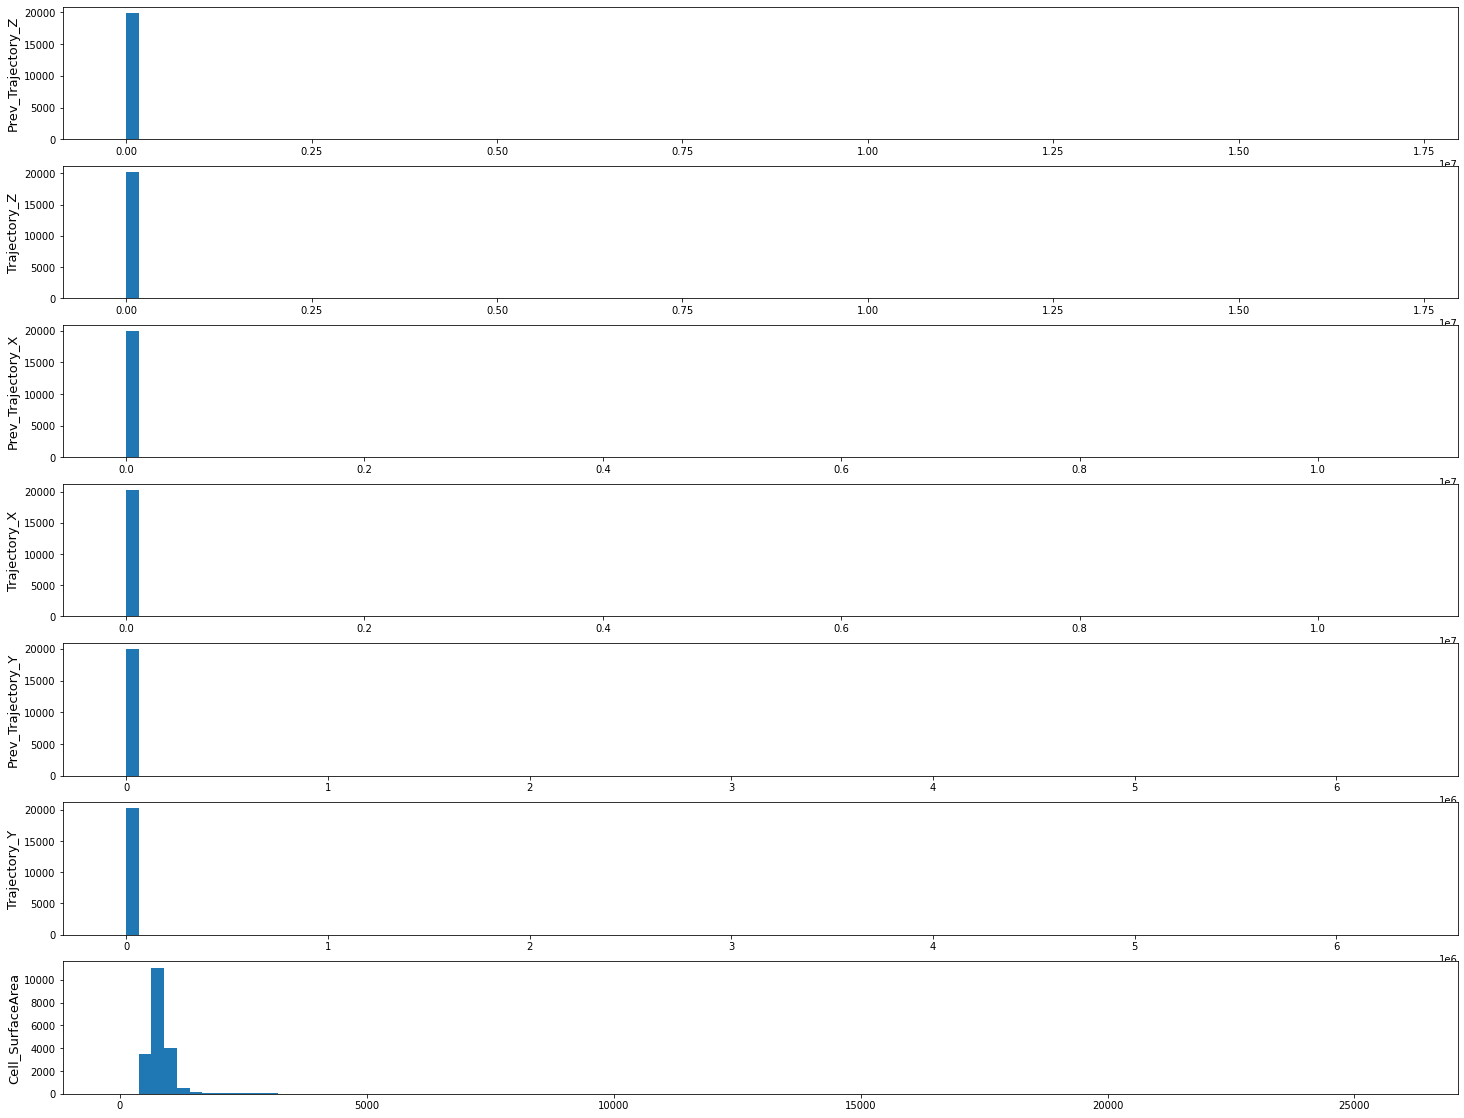

In [2]:
#################### Check shape distributions for extreme outliers before PCA ####################
import matplotlib.pyplot as plt
from CustomFunctions.file_management import multicsv
folder_fl = 'E:/Aaron/ParaNitroBlebbistatin_37C/'
data_fl = folder_fl + 'Data_and_Figs/'
info_fl = folder_fl + 'Processed_Data/'

#open full dataframe
df = pd.read_csv(data_fl + 'Shape_Metrics.csv')

excludes = pd.read_csv(data_fl + 'ListToExclude.csv', index_col=0)
exlist = [i.replace('_segmented.tiff', '') for i in excludes.iloc[:,0].to_list()]
df = df.loc[[x for x in df.index if x not in exlist]]

#add all of the other metrics from the single csv files
if __name__ == '__main__':
    pool = multiprocessing.Pool(processes=60)
    csvlist = [info_fl + i +'_cell_info.csv' for i in df.cell.to_list()]
    celllist = pool.map(multicsv, csvlist)
    pool.close()
    pool.join()
cellinfo = pd.concat(celllist)
# Add distance travelled per framerate to total frame
df = df.merge(cellinfo.drop(columns=['image', 'cropx (pixels)',
       'cropy (pixels)', 'cropz (pixels)']), left_on = 'cell', right_on = 'cell')

metrics = df.std().sort_values(ascending = False).index[:7]
# df = df[(df.Cell_Volume < 2070) & (df.Cell_Volume > 498)]
# df = df[df.Cell_SurfaceArea < 1800]
fig, axes = plt.subplots(len(metrics), 1, figsize=(25,20))#, sharex=True)
for i, ax in enumerate(axes):
    ax.hist(abs(df[metrics[i]]), 100) #, 30, (-2,2))
    ax.set_ylabel(metrics[i], fontsize = 13)
# #volume threshold determined by looking through cropped cell images
newdf = df[(df.Cell_Volume < 2070) & (df.Cell_Volume > 498)].copy()
newdf = newdf[(newdf.Cell_SurfaceArea < 1800) & (newdf.Cell_SurfaceArea > 500)]

newdf.to_csv(data_fl + 'Shape_Metrics_outliersremoved.csv')

In [15]:
df.Cell_Volume.sort_values(ascending=False).head(250)
# df.Cell_Volume.std()*3.5

cell
20231019_488EGFP-CAAX_2_cell_0_frame_125      41171.824758
20231019_488EGFP-CAAX_2_cell_0_frame_126      39045.207103
20231019_488EGFP-CAAX_1_cell_32_frame_303     35755.608704
20231020_488EGFP-CAAX_1_cell_61_frame_231     34064.992314
20231020_488EGFP-CAAX_1_cell_11_frame_136     33175.861057
                                                  ...     
20231019_488EGFP-CAAX_1_cell_99_frame_218      2479.344193
20231019_488EGFP-CAAX_1_cell_115_frame_351     2470.686063
20231019_488EGFP-CAAX_1_cell_140_frame_319     2467.212039
20231020_488EGFP-CAAX_1_cell_129_frame_280     2458.164162
20231019_488EGFP-CAAX_1_cell_140_frame_293     2456.941206
Name: Cell_Volume, Length: 250, dtype: float64